In [1]:
import os
# from tqdm import tqdm
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import copy
from torchsummary import summary
#Confusion matrix:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler

In [3]:
import utils

In [4]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [56]:
DATA_DIR = '/Users/melikakeshavarz/desktop/fma/data/fma_small'

tracks = utils.load('/Users/melikakeshavarz/desktop/fma/data/fma_metadata/tracks.csv')
features = utils.load('/Users/melikakeshavarz/desktop/fma/data/fma_metadata/features.csv')#annotation files
echonest = utils.load('/Users/melikakeshavarz/desktop/fma/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

train = tracks.index[tracks['set', 'split'] == 'training'] #bunch of indexes (not ids) for training val and test
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

Not enough Echonest features: (13129, 767)


In [69]:
#From data to one hot labels
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot_Ten = torch.tensor(labels_onehot)
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)




#from onehot labels to encoded targets.
targets = torch.argmax(labels_onehot_Ten, dim=1)





In [7]:
#adding the ch_three attribute/option to create 3 channel spectrogram.

#for manual spectogram we used one channel, but for the prepared one from pytorch we used 3 channel spectogram

#three channels are simply just a 3 replicas of 1 channel spectrogram.





from torch.utils.data import Dataset, DataLoader


#custome dataset class
class FMA(Dataset):
    def __init__(self, data_dir, track_ids,
                 target_sample_rate, transformation, num_samples, device , twoD = False, paper_cut = False):
        self.data_dir = data_dir
        self.track_ids = track_ids
        self.filenames = os.listdir(data_dir)
        self.target_sample_rate = target_sample_rate
        self.device = device
        self.transformation = transformation.to(self.device)
        self.twoD = twoD
        self.num_samples = num_samples
        self.paper_cut = paper_cut

        
        

    def __getitem__(self, index):
        tid = self.track_ids[index]
        filepath = utils.get_audio_path(self.data_dir, tid)
        label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        waveform, sr = torchaudio.load(filepath)#be careful all of the sample rates aren't the same(resample)
        #waveform --> (2, 10000) #(number of channels, number of samples)
        waveform = waveform.to(self.device)
        waveform = self._resample_if_necessary(waveform, sr)
        waveform = self._mix_down_if_necessary(waveform)
        #we have to adjust the length of the audio waveforms before the transformation
        waveform = self._cut_if_necessary(waveform)
        waveform = self._right_pad_if_necessary(waveform)
        if self.twoD == True:
            waveform = self.transformation(waveform)
        else:
            pass
        
        
        if self.paper_cut == True:
            waveform = waveform[:, :128, :513]
        else:
            pass
        
        

        return waveform, label
    
    
    def _cut_if_necessary(self, waveform):
        #this method happens before the transformation
        if waveform.shape[1] > self.num_samples:
            waveform = waveform[:, :self.num_samples]
            return waveform
        
        
    def _right_pad_if_necessary(self, waveform):
        if waveform.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - waveform.shape[1]
            last_dim_padding = (0,num_missing_samples) # (1, 2) -> (left, right)   
            #(1, 2, 0, 1) -> (left, right, padnumleft, padnumright)
            # what happens is : [1, 1, 1] --> [0, 1, 1, 1, 0, 0]
            waveform = torch.nn.functional.pad(waveform, last_dim_padding)
            waveform = waveform.T
        return waveform
    
    
        
    def _resample_if_necessary(self, waveform , sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            waveform = resampler(waveform)
        return waveform
    
    
    #from (2, 10000) to (1, 0000) taking the average between two waveforms
    def _mix_down_if_necessary(self, waveform):
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform , dim = 0, keepdim = True)
        return waveform
        

        
        return waveform.T, label 
    
    def __len__(self):#just gives us the number of samples in our datasets.
        return len(self.filenames) 

        

        

In [8]:
#trying the class:

if __name__ == "__main__":
    

    SAMPLE_RATE=44100
    
    #maxlength
    NUM_SAMPLES = 1320000
    #working on GPU
    if torch.cuda.is_available():
        Device = "cuda"
    else:
        Device = "cpu"
        
    print(f"we are using {Device}.")  
    
    #50% hop_length is the best for accuracy
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE, n_fft = 1024, hop_length = 256,
                                                        n_mels = 64) 
    
    n_fft = 1024    # FFT window size
    hop_length = 256    # number of samples between successive frames
    win_length = n_fft
    
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length = 256, win_length = win_length )
    
    
    
    FL = FMA(DATA_DIR, train, SAMPLE_RATE, spectrogram, NUM_SAMPLES, Device, twoD =True)
    print(f"there are {len(FL)} samples in the dataset" )
    waveform, label = FL[0] #track number 2
    a = 1
    
    


we are using cpu.
there are 158 samples in the dataset


# ResNet34, ResNet18, 

In [9]:
from torchvision.models import resnet34, ResNet34_Weights
model = resnet34(weights=ResNet34_Weights.DEFAULT)




model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 8, bias = True)

In [10]:
BATCH = 16


FL = FMA(DATA_DIR, train, SAMPLE_RATE,spectrogram, NUM_SAMPLES, Device, twoD =True, paper_cut = True)
val_dataset = FMA(DATA_DIR, val, SAMPLE_RATE, spectrogram, NUM_SAMPLES, Device, twoD =True, paper_cut = True)



val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)
dataloader = torch.utils.data.DataLoader(FL, batch_size=BATCH, shuffle=True)


#the Original ResNet34
model.to(device)


loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)



num_epochs = 10
i = 0
running_loss = 0.0



train_acc34 = []
val_acc34 = [] 


# train the model
for epoch in range(num_epochs):
    # evaluate the model on the training dataset
    model.train()
    train_correct = 0
    train_total = 0
    for waveform, label in dataloader:
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)

        # clear the gradients
        optimizer.zero_grad()

        # forward pass
        waveform = waveform.squeeze(0)


        
        waveform = waveform.to(device)
        output = model(waveform)
        

        

        loss = loss_fn(output, label)

        # backward pass
        loss.backward()
        optimizer.step()  
        
        # Update the learning rate
        scheduler.step(loss)
            
        _, train_predicted = torch.max(output.data, 1)
        train_total += train_label.size(0)
        train_correct += (train_predicted == train_label).sum().item()
        # print statistics
        i += 1
        running_loss += loss.item()
        
        
    train_a = train_correct / train_total        
    train_acc34.append(train_a)       
    #print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i*BATCH, running_loss / len(dataloader)))
    running_loss = 0            
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        model.eval()
        for val_waveform, val_label in val_dataloader:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)
            val_waveform = val_waveform.squeeze(0)
            
            val_waveform = val_waveform.to(device)
            val_output = model(val_waveform)
            val_loss += loss_fn(val_output, val_label).item()
            _, val_predicted = torch.max(val_output.data, 1)
            val_total += val_label.size(0)
            val_correct += (val_predicted == val_label).sum().item()
            
            
    val_a = val_correct/ val_total
    val_acc34.append(val_a)
    #print('Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(val_loss / len(val_dataloader), val_correct / val_total, train_correct / train_total))
print('Finished Training')

Finished Training


In [76]:
from torchvision.models import resnet18,ResNet18_Weights
model_2 = resnet18(weights=ResNet18_Weights.DEFAULT)




model_2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_2.fc = nn.Linear(512, 8, bias = True)

In [77]:
BATCH = 16


FL = FMA(DATA_DIR, train, SAMPLE_RATE,spectrogram, NUM_SAMPLES, Device, twoD =True, paper_cut = True)
val_dataset = FMA(DATA_DIR, val, SAMPLE_RATE, spectrogram, NUM_SAMPLES, Device, twoD =True, paper_cut = True)



val_dataloader18 = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)
dataloader = torch.utils.data.DataLoader(FL, batch_size=BATCH, shuffle=True)


#the Original ResNet34
model_2.to(device)


loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)



num_epochs = 10
i = 0
running_loss = 0.0




val_acc18 = []
train_acc18 = []


# train the model
for epoch in range(num_epochs):
    # evaluate the model on the training dataset
    model.train()
    train_correct18 = 0
    train_total18 = 0
    for waveform, label in dataloader:
        label = label.to(device)
        train_label = torch.argmax(label, dim=1)

        # clear the gradients
        optimizer.zero_grad()

        # forward pass
        waveform = waveform.squeeze(0)


        
        waveform = waveform.to(device)
        output = model(waveform)
        
        

        

        loss = loss_fn(output, label)

        # backward pass
        loss.backward()
        optimizer.step()  
        
        # Update the learning rate
        scheduler.step(loss)
            
        _, train_predicted = torch.max(output.data, 1)
        train_total18 += train_label.size(0)
        train_correct18 += (train_predicted == train_label).sum().item()
        # print statistics
        i += 1
        running_loss += loss.item()
    
        
    train_a = train_correct18 / train_total18       
    train_acc18.append(train_a)       
    #print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i*BATCH, running_loss / len(dataloader)))
    running_loss = 0            
    # evaluate the model on the validation dataset
    val_loss18 = 0.0
    val_correct18 = 0
    val_total18 = 0
    with torch.no_grad():
        model.eval()
        for val_waveform, val_label in val_dataloader18:
            val_label = val_label.to(device)
            val_label = torch.argmax(val_label, dim=1)
            val_waveform = val_waveform.squeeze(0)
            
            val_waveform = val_waveform.to(device)
            val_output = model(val_waveform)
            val_loss18 += loss_fn(val_output, val_label).item()
            _, val_predicted = torch.max(val_output.data, 1)
            val_total18 += val_label.size(0)
            val_correct18 += (val_predicted == val_label).sum().item()
            
            
    val_a = val_correct18 / val_total18
    val_acc18.append(val_a)
    #print('Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(val_loss18 / len(val_dataloader18), val_correct18 / val_total18, train_correct18 / train_total18))
print('Finished Training')

Finished Training


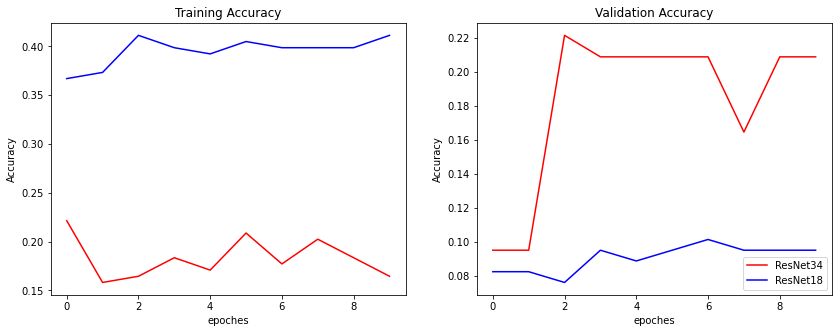

In [78]:
import matplotlib.pyplot as plt




epo_list = range(len(train_acc34))


fig, AX = plt.subplots(1, 2, figsize = (14, 5))

ax = AX[0]
ax.plot(epo_list, train_acc34, 'r', label = 'ResNet34')
ax.plot(epo_list, train_acc18, 'b', label = 'ResNet18')
ax.set_xlabel('epoches')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy')


ax = AX[1]
ax.plot(epo_list, val_acc34, 'r', label = 'ResNet34')
ax.plot(epo_list, val_acc18, 'b', label = 'ResNet18')
ax.set_xlabel('epoches')
ax.set_ylabel('Accuracy')
ax.set_title('Validation Accuracy')
plt.legend(loc = 'best')







# confusion matrix:

In [13]:
#we define a function to collect all the predictions.


FL = FMA(DATA_DIR, train, SAMPLE_RATE,spectrogram, NUM_SAMPLES, Device, twoD =True, paper_cut = True)
dataloader = torch.utils.data.DataLoader(FL, batch_size=BATCH, shuffle=True)

def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval() 
    
    for waveforms, labels in loader:
        waveforms = waveforms.to(device)
        labels = labels.to(device)
        labels = torch.argmax(labels, dim=1)

        preds = model(waveforms)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim = 0)
        
    
    return all_preds, all_labels





## confusion matrix for ResNet34:

In [72]:
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    
    #Please pay attention to the model input.
    preds, labels = get_all_preds(model, dataloader)


print('true labels: ', labels.numpy().astype(int))
print('pred labels: ', preds.argmax(dim=1).numpy())

stacked = torch.stack((labels.type(torch.int64), preds.argmax(dim=1)), dim=1)




# simply call the confusion_matrix function to build a confusion matrix
cm = confusion_matrix(labels.numpy().astype(int),preds.argmax(dim=1).numpy())
print(cm)

true labels:  [1 7 1 1 2 2 2 2 2 5 7 2 6 5 6 6 2 5 2 2 7 1 7 2 2 1 2 2 1 6 2 0 2 3 5 7 3
 5 1 7 1 2 2 1 6 7 7 2 2 7 3 2 5 7 5 0 7 7 2 7 6 6 1 2 2 7 7 1 1 5 2 5 6 7
 2 2 2 2 7 2 7 2 2 6 2 2 1 2 2 5 2 5 5 2 5 2 2 6 2 6 2 2 2 5 2 2 2 5 2 7 2
 7 2 2 7 5 7 5 7 2 2 5 3 1 2 7 7 2 6 1 7 6 2 7 5 2 2 6 7 7 1 6 1 7 6 2 5 2
 1 2 7 2 5 6 2 2 3 1]
pred labels:  [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 2 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 2 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5]
[[ 0  0  1  0  1  0  0]
 [ 0  0  1  0 15  0  3]
 [ 0  0  0  0 62  0  1]
 [ 0  0  0  0  5  0  0]
 [ 0  0  0  0 21  0  0]
 [ 0  0  0  0 17  0  0]
 [ 0  0  1  0 29  0  1]]


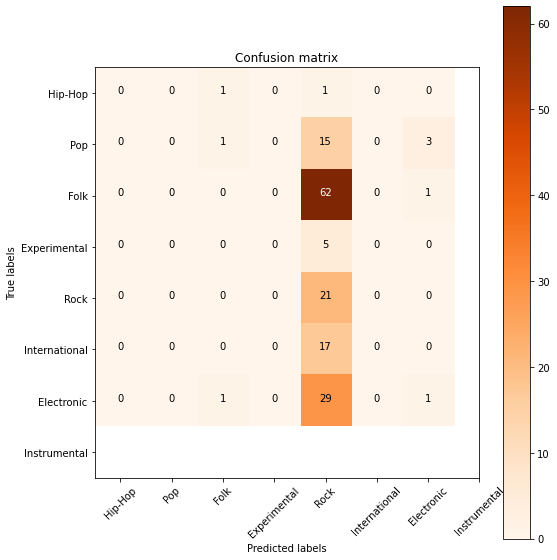

In [74]:


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):

     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
genre = tracks.track.genre_top.unique().to_list()

plot_confusion_matrix(cm, genre)

## confusion matrix for ResNet18:

In [79]:
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    
    #Please pay attention to the model input.
    preds, labels = get_all_preds(model_2, dataloader)


print('true labels: ', labels.numpy().astype(int))
print('pred labels: ', preds.argmax(dim=1).numpy())

stacked = torch.stack((labels.type(torch.int64), preds.argmax(dim=1)), dim=1)




# simply call the confusion_matrix function to build a confusion matrix
cm = confusion_matrix(labels.numpy().astype(int),preds.argmax(dim=1).numpy())
print(cm)

true labels:  [2 1 1 2 2 3 5 7 3 6 2 6 2 2 2 1 2 2 5 7 7 5 5 5 7 2 1 1 7 7 1 2 2 7 1 2 2
 7 7 7 2 2 5 7 7 5 2 6 5 5 2 2 2 7 7 0 7 7 5 2 7 6 2 6 6 2 6 6 5 7 2 5 2 7
 7 2 6 2 2 2 7 3 2 6 2 2 2 2 7 1 5 2 7 2 7 2 1 2 0 2 7 5 3 2 6 2 7 6 2 5 6
 2 2 1 1 2 5 2 2 2 2 5 6 6 2 2 1 2 2 2 5 7 7 5 7 2 2 7 2 1 1 2 2 2 6 1 7 5
 5 1 1 3 1 1 6 2 2 2]
pred labels:  [4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 7 4 4 5 4 4 4 4 4 4 0 4 4 4 4 0 4 4 4 2 7 4 4 4 4 4 4 4 7 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4
 4 4 4 4 4 7 4 4 4 4]
[[ 0  0  0  0  2  0  0  0]
 [ 0  0  1  0 16  1  0  1]
 [ 2  0  0  0 58  0  0  3]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0]
 [ 0  0  0  0 17  0  0  0]
 [ 1  0  0  0 28  2  0  0]]


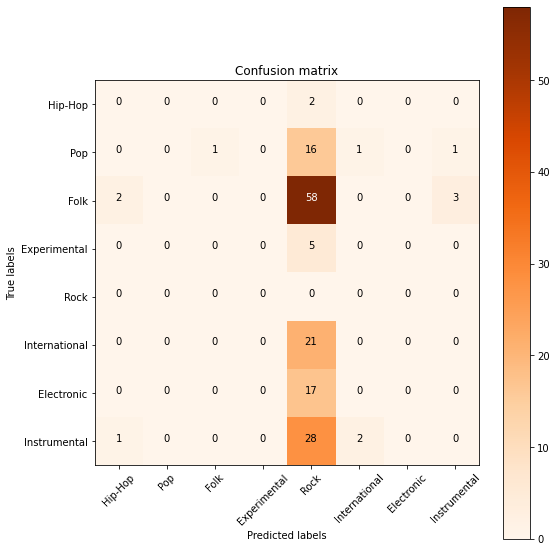

In [80]:


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):

     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
genre = tracks.track.genre_top.unique().to_list()

plot_confusion_matrix(cm, genre)